In [10]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

from datetime import datetime


from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils


In [3]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)

import utils
from utils import load_df, zscore, get_colors


import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [ ]:
data_orig = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)
data_origT = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
    index_col="subid",
)

MS_patients = data_orig["dz_type2"] == "MS"
NONMS_patients = data_orig["dz_type2"] == "!MS"
NIND_patients = data_orig["dz_type5"] == "NIND"
OIND_patients = data_orig["dz_type5"] == "OIND"
RMS_patients = data_orig["dz_type5"] == "RMS"
PMS_patients = data_orig["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data_orig[MS_patients]
data_ms_z = zscore(data_ms)

grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}



In [34]:
thomas_long = pd.read_csv("/home/srs-9/Projects/ms_mri/data/longitudinal/mean_volumes3.csv", index_col="subid")
thomas_long['time1'] = thomas_long['time1'].map(str)
thomas_long['time2'] = thomas_long['time2'].map(str)

date_format = "%Y%m%d"
delta = thomas_long['time2'].apply(datetime.strptime, args=(date_format,)) - thomas_long['time1'].apply(datetime.strptime, args=(date_format,))
thomas_long['t_delta'] = delta.apply(lambda x: x.days/365)

for struct in hips_thomas_ref:
    thomas_long[f"{struct}_change"] = (thomas_long[f"{struct}_time2"] - thomas_long[f"{struct}_time1"]) / thomas_long[f"{struct}_time1"]

In [35]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")

mean_thomas_vols = data_orig[hips_thomas_ref].rename(columns=hips_thomas_invref).mean()

# CP distances
choroid_dists_left = pd.read_csv(
    data_dir / "centroid-choroid_centroid-left.csv", index_col="subid"
)
choroid_dists_right = pd.read_csv(
    data_dir / "centroid-choroid_centroid-right.csv", index_col="subid"
)
choroid_dists = (choroid_dists_left + choroid_dists_right) / 2
new_cols = {str(i): f"{k}_CP_dist" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([choroid_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_choroid_dists = choroid_dists.mean()
mean_choroid_dists.index = mean_choroid_dists.index.map(int)


# Ventricle SDT distances
ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_sdt_dists = (ventricle_dists_sdt_right + ventricle_dists_sdt_left) / 2
new_cols = {str(i): f"{k}_LV_sdt" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([ventricle_sdt_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_ventricle_sdt_dists = ventricle_sdt_dists.mean()
mean_ventricle_sdt_dists.index = mean_ventricle_sdt_dists.index.map(int)


# Load other MNI dists
mni_outerCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_outerCSF_dists["dist"] = (
    mni_outerCSF_dists["left_exposure"] + mni_outerCSF_dists["right_exposure"]
) / 2
mni_outerCSF_dists = mni_outerCSF_dists["dist"]

test_dist = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_shortestSDT_tmp.csv", index_col="index"
)['left_exposure']
mni_allCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_allCSF_dists["dist"] = (
    mni_allCSF_dists["left_exposure"] + mni_allCSF_dists["right_exposure"]
) / 2
mni_allCSF_dists = mni_allCSF_dists["dist"]

mni_allCSF_dists_norm = mni_allCSF_dists / (mean_thomas_vols**(1/3))

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_ventricle_dists["dist"] = (
    mni_ventricle_dists["left_exposure"] + mni_ventricle_dists["right_exposure"]
) / 2
mni_ventricle_dists = mni_ventricle_dists["dist"]

mni_viewfactors = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1.csv", index_col="index")['dose']
mni_viewfactors_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1_norm.csv", index_col="index")['dose']

mni_viewfactors2 = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_midlineCSF.csv", index_col="index")['dose']
mni_viewfactors2_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_midlineCSF_norm.csv", index_col="index")['dose']

mni_viewfactors3 = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_ventricle_system.csv", index_col="index")['dose']
mni_viewfactors3_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_ventricle_system_norm.csv", index_col="index")['dose']

In [46]:
model_data = thomas_long.copy().join(data_orig[['CP', 'age', 'Female', 'tiv', 'dzdur']])
model_data = model_data[MS_patients]

/tmp/ipykernel_262191/2260934861.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_data = model_data[MS_patients]


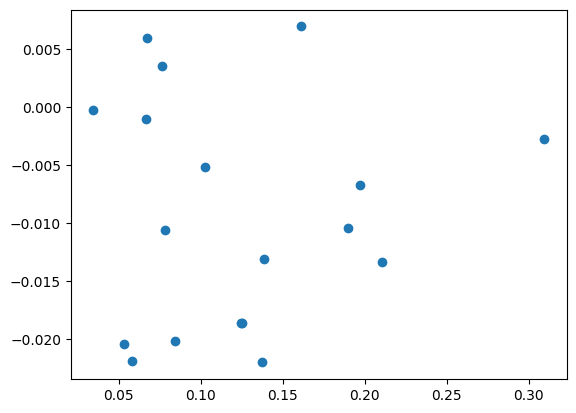

In [44]:
plot_data = {
    'change': [model_data[f"{struct}_change"].mean() for struct in hips_thomas_ref[thalamic_nuclei+deep_grey]],
    'CP_dists': [mean_choroid_dists[hips_thomas_invref[struct]] for struct in hips_thomas_ref[thalamic_nuclei+deep_grey]],
    'viewfactor_norm': [mni_viewfactors_norm[hips_thomas_invref[struct]] for struct in hips_thomas_ref[thalamic_nuclei+deep_grey]]
}

plt.scatter(plot_data['viewfactor_norm'], plot_data['change'])

In [47]:
formula = "THALAMUS_1_change ~ CP + age + Female + tiv"
model = sm.OLS.from_formula(formula, data=model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      THALAMUS_1_change   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.981
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.106
Time:                        15:54:27   Log-Likelihood:                 175.77
No. Observations:                  78   AIC:                            -341.5
Df Residuals:                      73   BIC:                            -329.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0563      0.051     -1.113      0.2